In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

In [141]:
# Set random seed for reproducibility
np.random.seed(0)

# Generate a hypothetical dataset
n = 10000
data = pd.DataFrame({
    'user_id': np.arange(n),
    'age': np.random.randint(18, 65, size=n),
    'gender': np.random.choice(['Male', 'Female'], size=n),
    'device': np.random.choice(['Mobile', 'Desktop', 'Tablet'], size=n),
    'selection_algo': np.random.choice(['Algo1', 'Algo2', 'Algo3'], size=n),
    'click_through_rate': np.random.rand(n),
    'conversion_rate': np.random.rand(n)
})

In [142]:
data.head()

,user_id,age,gender,device,selection_algo,click_through_rate,conversion_rate
0,0,62,Male,Mobile,Algo3,0.915128,0.798305
1,1,18,Male,Tablet,Algo1,0.306227,0.130618
2,2,21,Female,Mobile,Algo2,0.497239,0.968703
3,3,21,Female,Tablet,Algo2,0.902578,0.300068
4,4,57,Female,Tablet,Algo3,0.448165,0.104813


In [143]:
data.describe()

,user_id,age,click_through_rate,conversion_rate
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,41.137400,0.496698,0.500967
std,2886.89568,13.615574,0.287245,0.288268
min,0.00000,18.000000,0.000024,0.000146
25%,2499.75000,29.000000,0.251512,0.250474
50%,4999.50000,41.000000,0.491771,0.502464
75%,7499.25000,53.000000,0.745318,0.749503
max,9999.00000,64.000000,0.999865,0.999999


array([[<AxesSubplot: title={'center': 'Desktop'}>,
        <AxesSubplot: title={'center': 'Mobile'}>],
       [<AxesSubplot: title={'center': 'Tablet'}>, <AxesSubplot: >]],
      dtype=object)

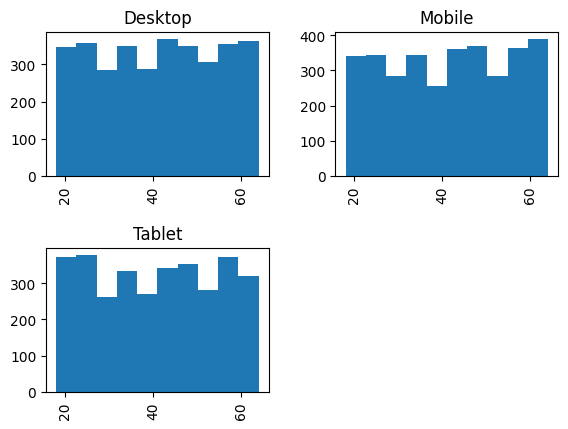

In [144]:
data[['age', 'device']].hist(by='device')

array([[<AxesSubplot: title={'center': 'Desktop'}>,
        <AxesSubplot: title={'center': 'Mobile'}>],
       [<AxesSubplot: title={'center': 'Tablet'}>, <AxesSubplot: >]],
      dtype=object)

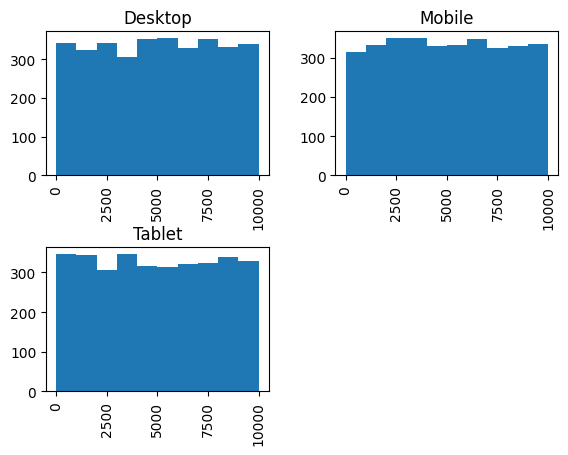

In [145]:
data[['user_id', 'device']].hist(by='device')

<AxesSubplot: >

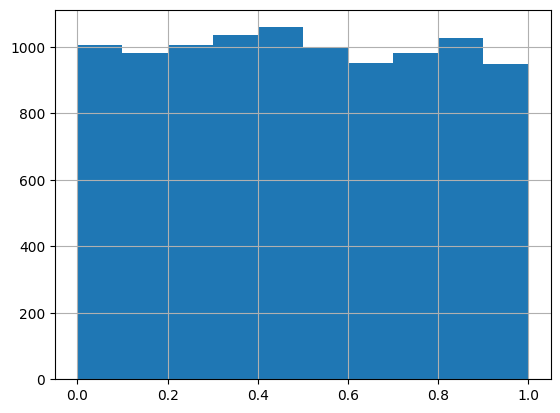

In [146]:
data['click_through_rate'].hist()

In [147]:
data.groupby(data['selection_algo']).agg(ctr_mean=('click_through_rate', 'mean'), cvr_mean=('conversion_rate', 'mean'))

,ctr_mean,cvr_mean
selection_algo,,
Algo1,0.494899,0.507231
Algo2,0.496180,0.496672
Algo3,0.499061,0.498989


In [148]:
# Simulate some differences in performance based on algorithms
data.loc[data['selection_algo'] == 'Algo1', 'click_through_rate'] *= 1.1
data.loc[data['selection_algo'] == 'Algo2', 'conversion_rate'] *= 1.2

In [149]:
data.groupby(data['selection_algo']).agg(ctr_mean=('click_through_rate', 'mean'), cvr_mean=('conversion_rate', 'mean'))

,ctr_mean,cvr_mean
selection_algo,,
Algo1,0.544389,0.507231
Algo2,0.496180,0.596006
Algo3,0.499061,0.498989


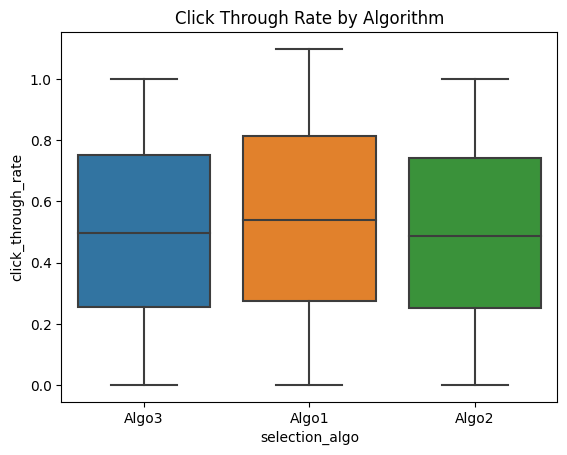

In [150]:
sns.boxplot(x='selection_algo', y='click_through_rate', data=data)
plt.title('Click Through Rate by Algorithm')
plt.show()

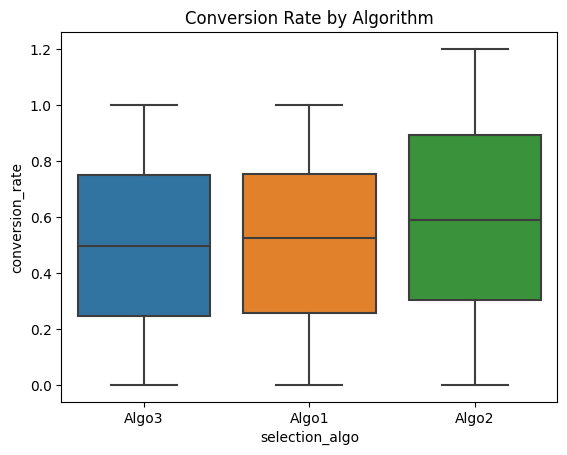

In [151]:
sns.boxplot(x='selection_algo', y='conversion_rate', data=data)
plt.title('Conversion Rate by Algorithm')
plt.show()

In [152]:
cvr_algo1 = data[data['selection_algo'] == 'Algo1']['conversion_rate']
cvr_algo2 = data[data['selection_algo'] == 'Algo2']['conversion_rate']
cvr_algo3 = data[data['selection_algo'] == 'Algo3']['conversion_rate']

In [153]:
t_stat, p_val = ttest_ind(cvr_algo1, cvr_algo2)
print("Algo1 VS Algo2 t-stat:{}, p-val:{}".format(t_stat, p_val))

Algo1 VS Algo2 t-stat:-11.460773377153977, p-val:3.953857294039667e-30


In [154]:
t_stat, p_val = ttest_ind(cvr_algo1, cvr_algo3)
print("Algo1 VS Algo3 t-stat:{}, p-val:{}".format(t_stat, p_val))

Algo1 VS Algo3 t-stat:1.1624426664228846, p-val:0.24509753507943033


In [155]:
label_encoder = LabelEncoder()
data['selection_algo_id'] = label_encoder.fit_transform(data['selection_algo'])
data['device_type_id'] = label_encoder.fit_transform(data['device'])
data['gender_id'] = label_encoder.fit_transform(data['gender'])
data.head()

,user_id,age,gender,device,selection_algo,click_through_rate,conversion_rate,selection_algo_id,device_type_id,gender_id
0,0,62,Male,Mobile,Algo3,0.915128,0.798305,2,1,1
1,1,18,Male,Tablet,Algo1,0.336850,0.130618,0,2,1
2,2,21,Female,Mobile,Algo2,0.497239,1.162444,1,1,0
3,3,21,Female,Tablet,Algo2,0.902578,0.360081,1,2,0
4,4,57,Female,Tablet,Algo3,0.448165,0.104813,2,2,0


In [156]:
data_features = data.drop('gender', axis=1).drop('device', axis=1).drop('selection_algo', axis=1)
data_features.head()

,user_id,age,click_through_rate,conversion_rate,selection_algo_id,device_type_id,gender_id
0,0,62,0.915128,0.798305,2,1,1
1,1,18,0.336850,0.130618,0,2,1
2,2,21,0.497239,1.162444,1,1,0
3,3,21,0.902578,0.360081,1,2,0
4,4,57,0.448165,0.104813,2,2,0


In [157]:
data_features.groupby(['age', 'selection_algo_id', 'device_type_id', 'gender_id'], as_index=False).agg(ctr_mean=('click_through_rate', 'mean'), cvr_mean=('conversion_rate', 'mean'))

,age,selection_algo_id,device_type_id,gender_id,ctr_mean,cvr_mean
0,18,0,0,0,0.331457,0.617836
1,18,0,0,1,0.322216,0.345372
2,18,0,1,0,0.557203,0.538849
3,18,0,1,1,0.441117,0.700230
4,18,0,2,0,0.569273,0.562861
...,...,...,...,...,...,...
841,64,2,0,1,0.585724,0.389273
842,64,2,1,0,0.547871,0.612538
843,64,2,1,1,0.654037,0.768566
844,64,2,2,0,0.213272,0.461488


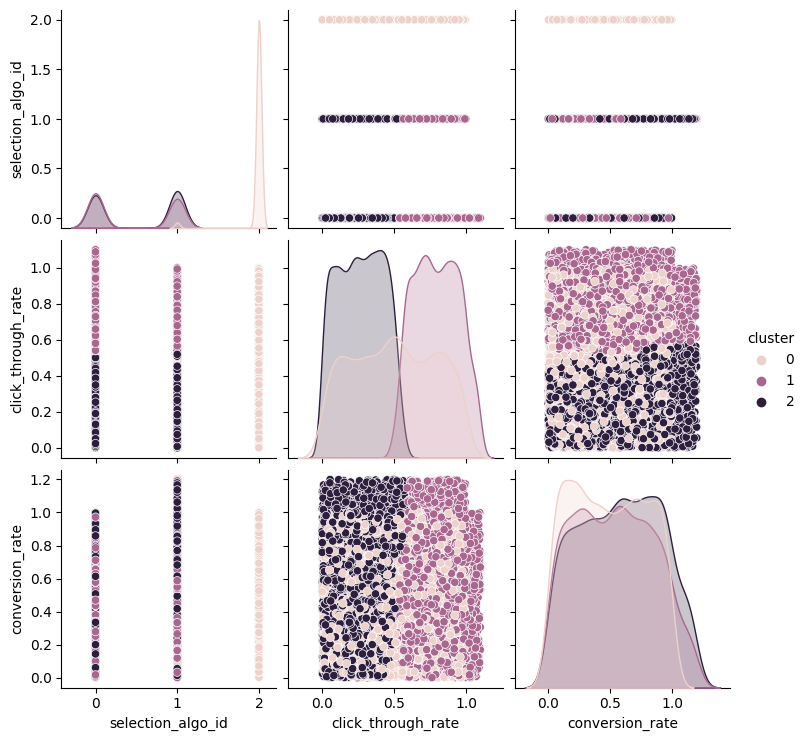

In [158]:
# Select features for clustering
features = ['selection_algo_id', 'click_through_rate', 'conversion_rate']
X = data_features[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
data_features['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
sns.pairplot(data_features, hue='cluster', vars=features)
plt.show()

In [159]:
data_features.drop('cluster', axis=1)

,user_id,age,click_through_rate,conversion_rate,selection_algo_id,device_type_id,gender_id
0,0,62,0.915128,0.798305,2,1,1
1,1,18,0.336850,0.130618,0,2,1
2,2,21,0.497239,1.162444,1,1,0
3,3,21,0.902578,0.360081,1,2,0
4,4,57,0.448165,0.104813,2,2,0
...,...,...,...,...,...,...,...
9995,9995,54,0.678608,0.333484,1,0,1
9996,9996,60,0.837894,0.587129,1,2,1
9997,9997,63,0.824595,0.693151,2,2,1
9998,9998,35,0.940486,0.710836,0,0,1


In [169]:
# Prepare the data for decision tree
X = data_features[['age', 'selection_algo_id', 'device_type_id', 'gender_id']]
y = data_features['click_through_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [170]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [171]:
# Make predictions
y_pred_train = gbr.predict(X_train)
y_pred_test = gbr.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f'Train MSE: {mse_train:.4f}, Train R2: {r2_train:.4f}')
print(f'Test MSE: {mse_test:.4f}, Test R2: {r2_test:.4f}')

Train MSE: 0.0864, Train R2: 0.0252
Test MSE: 0.0901, Test R2: -0.0054


             Feature  Importance
0                age    0.422948
1  selection_algo_id    0.363726
2     device_type_id    0.166453
3          gender_id    0.046872


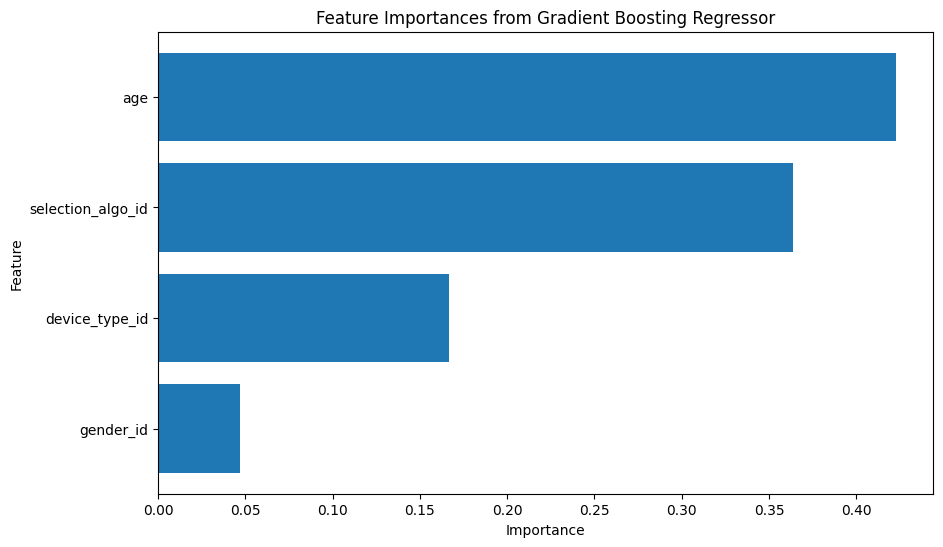

In [166]:
# Print feature importances
feature_importances = gbr.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boosting Regressor')
plt.gca().invert_yaxis()
plt.show()

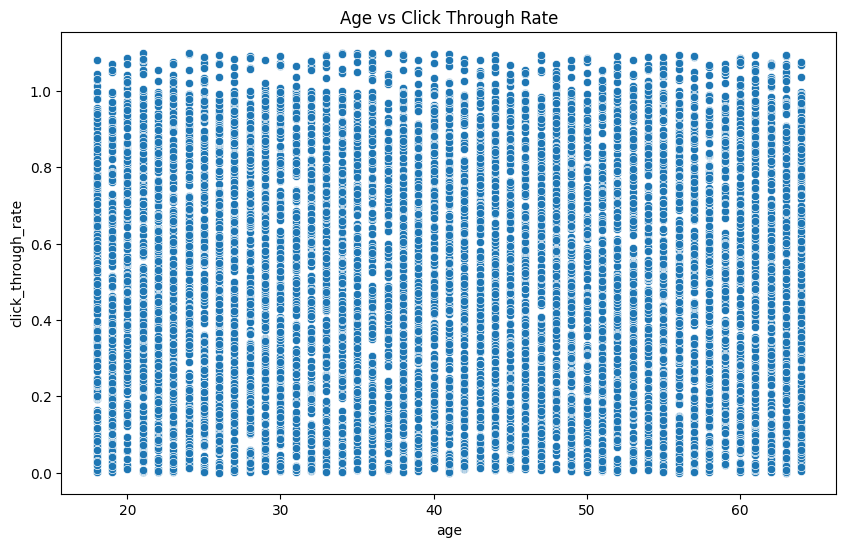

In [172]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='click_through_rate', data=data)
plt.title('Age vs Click Through Rate')
plt.show()

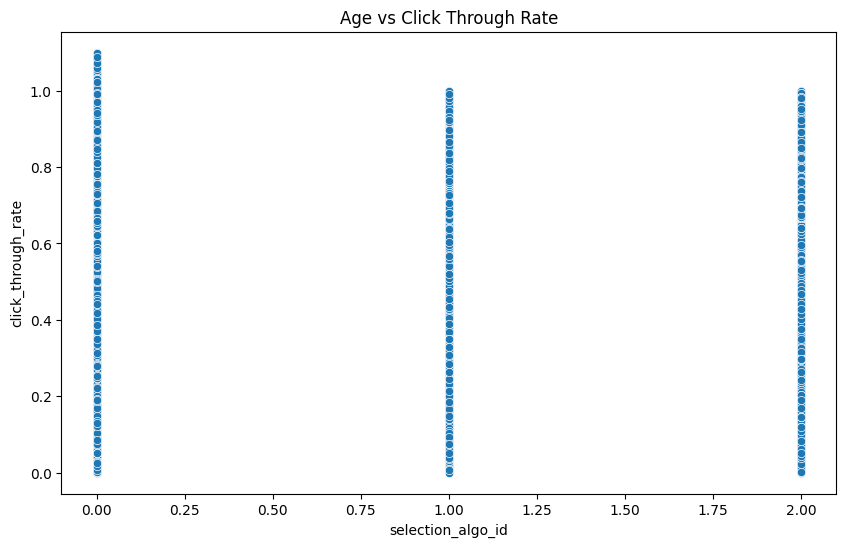

In [173]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='selection_algo_id', y='click_through_rate', data=data)
plt.title('Age vs Click Through Rate')
plt.show()

In [174]:
correlation_matrix = data.corr()
print(correlation_matrix['click_through_rate'].sort_values(ascending=False))

click_through_rate    1.000000
gender_id             0.014946
age                   0.006223
device_type_id       -0.003729
conversion_rate      -0.018734
user_id              -0.023452
selection_algo_id    -0.062160
Name: click_through_rate, dtype: float64


/var/folders/v3/rjvgj26d3616qp4699wl1zv40000gn/T/ipykernel_10843/489895726.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


In [186]:
# Create the CatBoost Pool
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Define the model
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    eval_metric='R2',
    random_seed=0,
    early_stopping_rounds=100,
    verbose=100
)

# Train the model
model.fit(train_pool, eval_set=test_pool)

0:	learn: 0.0013069	test: 0.0001849	best: 0.0001849 (0)	total: 1.25ms	remaining: 1.25s
100:	learn: 0.0327843	test: -0.0039332	best: 0.0015753 (5)	total: 105ms	remaining: 934ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.001575299235
bestIteration = 5

Shrink model to first 6 iterations.


In [187]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f'Train MSE: {mse_train:.4f}, Train R2: {r2_train:.4f}')
print(f'Test MSE: {mse_test:.4f}, Test R2: {r2_test:.4f}')

Train MSE: 0.0880, Train R2: 0.0061
Test MSE: 0.0894, Test R2: 0.0016


             Feature  Importance
1  selection_algo_id   70.447957
0                age   11.970793
3          gender_id    9.965423
2     device_type_id    7.615826


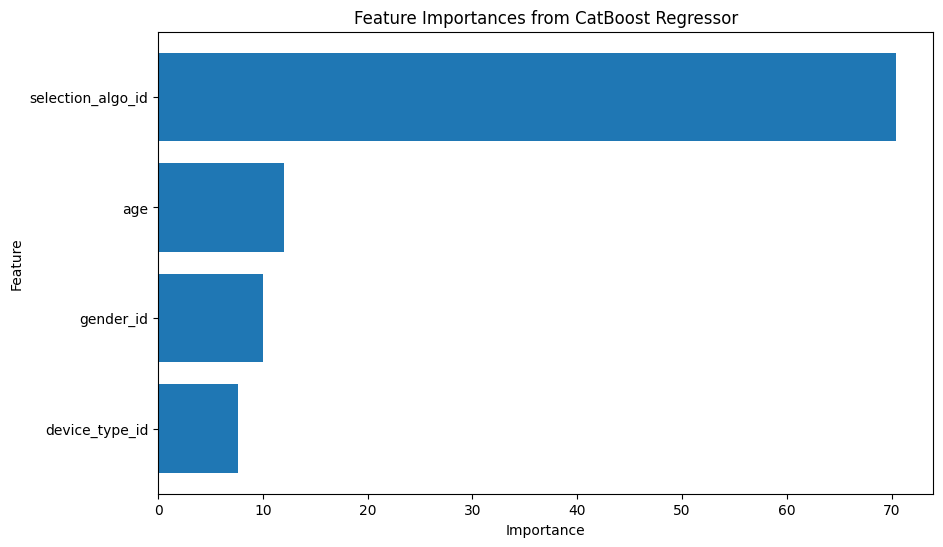

In [188]:
# Print feature importances
feature_importances = model.get_feature_importance()
features = X.columns

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from CatBoost Regressor')
plt.gca().invert_yaxis()
plt.show()

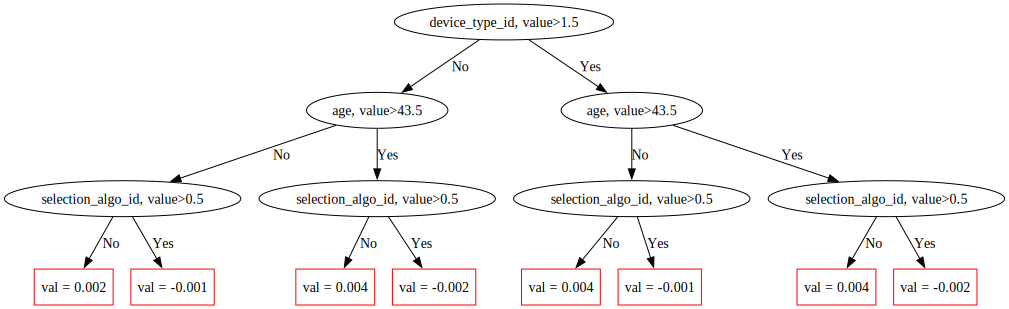

In [193]:
model.plot_tree(
    tree_idx=0,
    pool=test_pool
)